In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,classification_report, confusion_matrix
from xgboost import XGBClassifier
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from joblib import Parallel, delayed
from scipy.stats import t


pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', '{:.8f}'.format)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

logging.info("Loading data...")
df = pd.read_csv("~/Downloads/construction_data2.csv")

df = df.sample(frac=0.05, random_state=42)

logging.info("Converting time columns...")
df["Start_Time"] = pd.to_datetime(df["Start_Time"], format='mixed', errors='coerce')
df["End_Time"] = pd.to_datetime(df["End_Time"], format='mixed', errors='coerce')
df["Duration"] = (df["End_Time"] - df["Start_Time"]).dt.total_seconds() / 3600

logging.info("Encoding categorical variables...")
label_encoders = {}
for col in df.select_dtypes(include="object").columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

2025-04-03 20:47:11,973 - INFO - Loading data...
2025-04-03 20:47:25,086 - INFO - Converting time columns...
2025-04-03 20:47:25,187 - INFO - Encoding categorical variables...


2025-04-03 19:32:09,010 - INFO - Training models to predict severity level...
2025-04-03 19:32:10,893 - INFO - Training model: Logistic Regression...
2025-04-03 19:32:10,894 - INFO - Training model: Random Forest...
2025-04-03 19:32:10,894 - INFO - Training model: XGBoost...


🔹 Model: Logistic Regression
  Accuracy: 0.9093
  Precision: 0.8886
  Recall: 0.9093
  F1-score: 0.8922

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       183
           1       0.92      0.98      0.95    204583
           2       0.34      0.04      0.07      2531
           3       0.58      0.29      0.39     19923

    accuracy                           0.91    227220
   macro avg       0.71      0.33      0.35    227220
weighted avg       0.89      0.91      0.89    227220


🔹 Model: Random Forest
  Accuracy: 0.9855
  Precision: 0.9854
  Recall: 0.9855
  F1-score: 0.9850

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.37      0.51       183
           1       0.99      1.00      0.99    204583
           2       0.97      0.83      0.89      2531
           3       0.99      0.88      0.93     19923

    accuracy                          

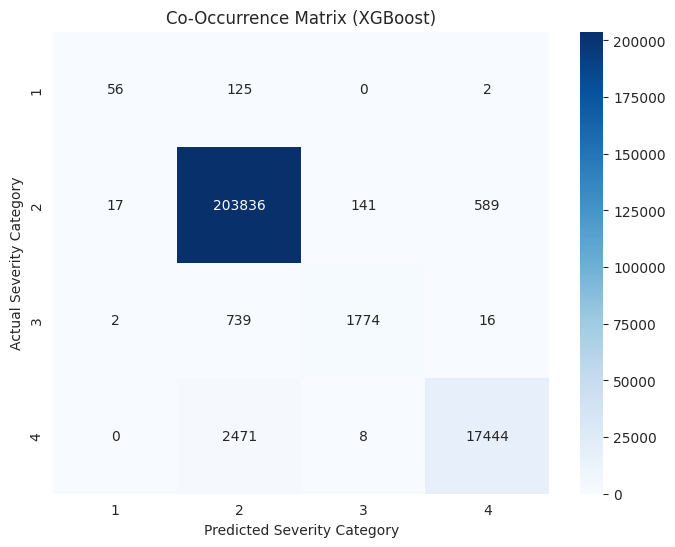

In [51]:
logging.info("Training models to predict severity level...")

X = df.drop(columns=["Severity", "ID", "Start_Time", "End_Time"])
y = df["Severity"] - 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1),
    "XGBoost": XGBClassifier(eval_metric="mlogloss", n_jobs=-1)
}

def train_and_evaluate(name, model):
    logging.info(f"Training model: {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

    class_report = classification_report(y_test, y_pred, zero_division=1)

    result = {
        'model': name,
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'y_pred': y_pred,
        'class_report': class_report
    }
    return result

results = Parallel(n_jobs=-1, backend="threading")(
    delayed(train_and_evaluate)(name, model) for name, model in models.items()
)

for result in results:
    print(f"🔹 Model: {result['model']}")
    print(f"  Accuracy: {result['accuracy']:.4f}")
    print(f"  Precision: {result['precision']:.4f}")
    print(f"  Recall: {result['recall']:.4f}")
    print(f"  F1-score: {result['f1']:.4f}")
    print("\n📊 Classification Report:")
    print(result['class_report'])
    print()

y_test_np = np.array(y_test)
y_pred_np = np.array(results[-1]['y_pred'])

conf_matrix = confusion_matrix(y_test_np, y_pred_np)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
plt.xlabel("Predicted Severity Category")
plt.ylabel("Actual Severity Category")
plt.title(f"Co-Occurrence Matrix ({results[-1]['model']})")
plt.show()

2025-04-03 20:13:13,623 - INFO - Beginning K-Means clustering on roadwork data...
2025-04-03 20:13:14,453 - INFO - Using 5 clusters for K-Means.
2025-04-03 20:13:14,454 - INFO - Visualizing K-Means clusters...


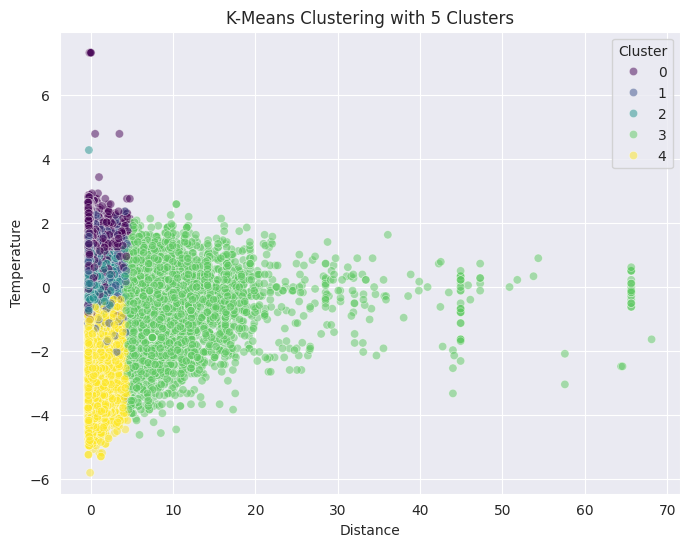

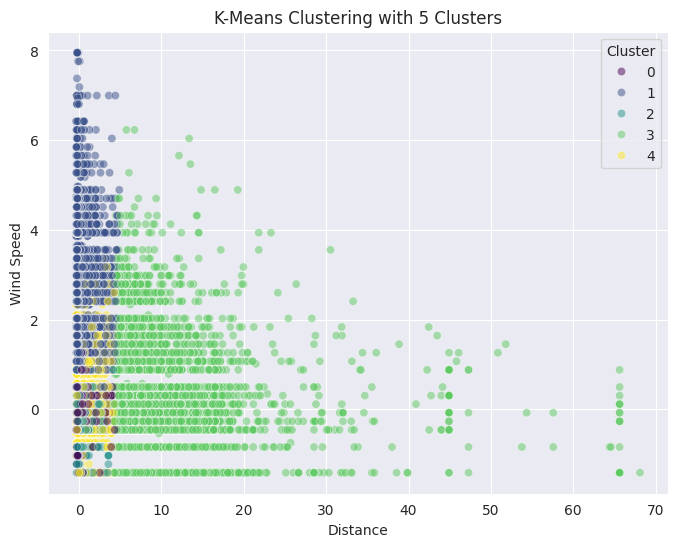

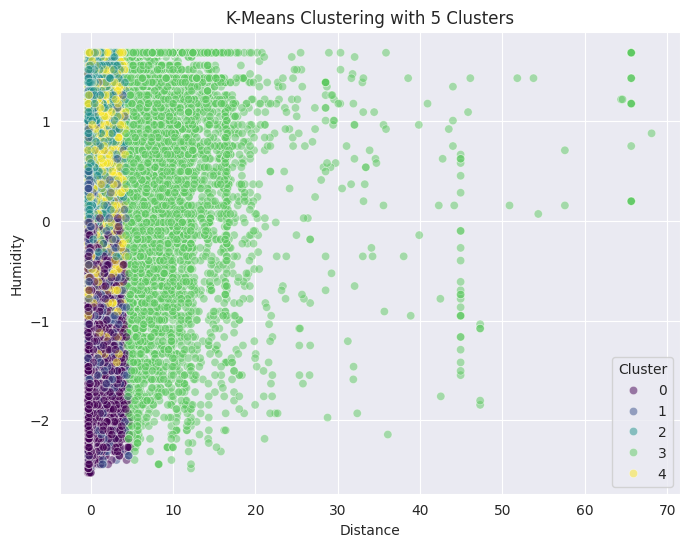

2025-04-03 20:14:23,561 - INFO - Visualizing K-Means clusters using PCA...


Feature contributions to each principal component:

     Distance(mi)  Temperature(F)  Wind_Speed(mph)  Humidity(%)
PC1    0.25737116     -0.61767636      -0.36796312   0.64563081
PC2    0.83542192     -0.07447984       0.53544203  -0.09912016


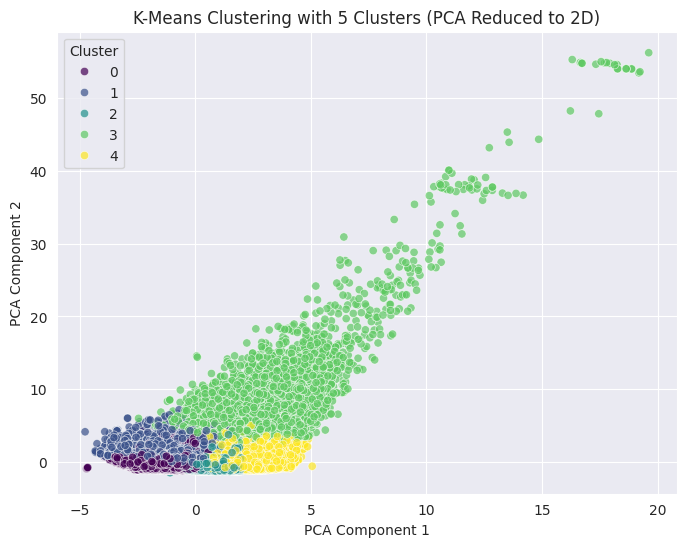

In [6]:
logging.info("Beginning K-Means clustering on roadwork data...")
df_filtered = df[df["Wind_Speed(mph)"] <= 50].copy()
X_clustering = df_filtered[["Distance(mi)", "Temperature(F)", "Wind_Speed(mph)", "Humidity(%)"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

inertia = []
silhouette_scores = []

for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), inertia, marker="o", color="b")
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), silhouette_scores, marker="o", color="r")
plt.title("Silhouette Score for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df_filtered["Cluster_KMeans"] = kmeans.fit_predict(X_scaled)

logging.info(f"Using {optimal_clusters} clusters for K-Means.")

logging.info("Visualizing K-Means clusters...")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=df_filtered["Cluster_KMeans"], palette="viridis", alpha=0.5)
plt.title(f"K-Means Clustering with {optimal_clusters} Clusters")
plt.xlabel("Distance")
plt.ylabel("Temperature")
plt.legend(title="Cluster")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 2], hue=df_filtered["Cluster_KMeans"], palette="viridis", alpha=0.5)
plt.title(f"K-Means Clustering with {optimal_clusters} Clusters")
plt.xlabel("Distance")
plt.ylabel("Wind Speed")
plt.legend(title="Cluster")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 3], hue=df_filtered["Cluster_KMeans"], palette="viridis", alpha=0.5)
plt.title(f"K-Means Clustering with {optimal_clusters} Clusters")
plt.xlabel("Distance")
plt.ylabel("Humidity")
plt.legend(title="Cluster")
plt.show()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Feature contributions to each principal component:")
components_df = pd.DataFrame(pca.components_, columns=X_clustering.columns, index=[f"PC{i+1}" for i in range(pca.n_components_)])
print("\n" + str(components_df))

logging.info("Visualizing K-Means clusters using PCA...")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_filtered["Cluster_KMeans"], palette="viridis", alpha=0.7)
plt.title(f"K-Means Clustering with {optimal_clusters} Clusters (PCA Reduced to 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()


2025-04-03 20:47:50,276 - INFO - Training models for construction duration prediction...
2025-04-03 20:47:50,319 - INFO - Training model: Linear Regression...
2025-04-03 20:47:50,319 - INFO - Training model: Random Forest Regressor...
2025-04-03 20:47:50,320 - INFO - Training model: XGBoost Regressor...



Linear Regression:
  MAE: 758.9198
  RMSE: 1721.1312
  R²: 0.0135
  95% CI: ±20.0172

Random Forest Regressor:
  MAE: 659.1461
  RMSE: 1548.7430
  R²: 0.2012
  95% CI: ±17.9868

XGBoost Regressor:
  MAE: 657.0739
  RMSE: 1568.8675
  R²: 0.1803
  95% CI: ±18.2454


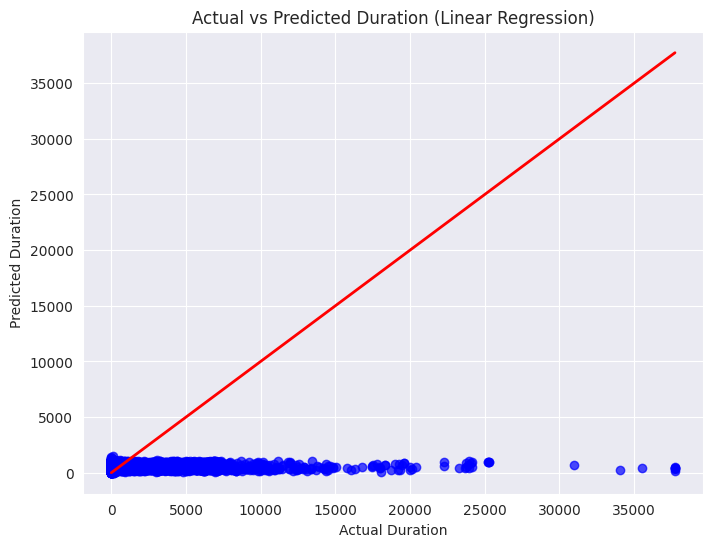

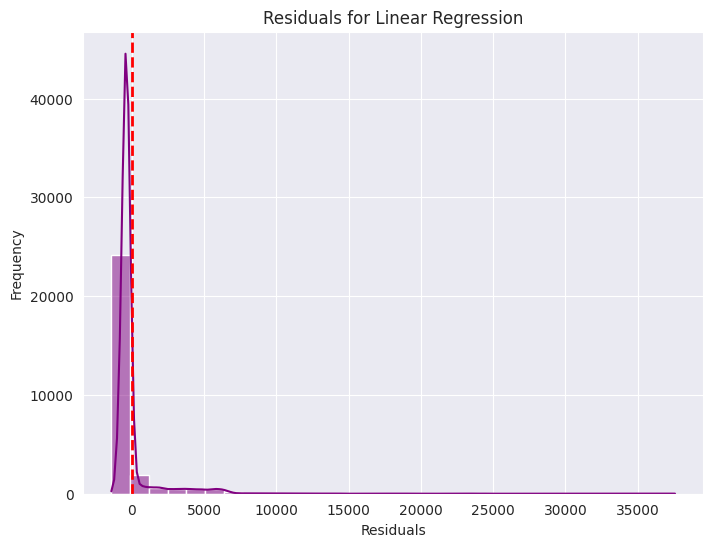

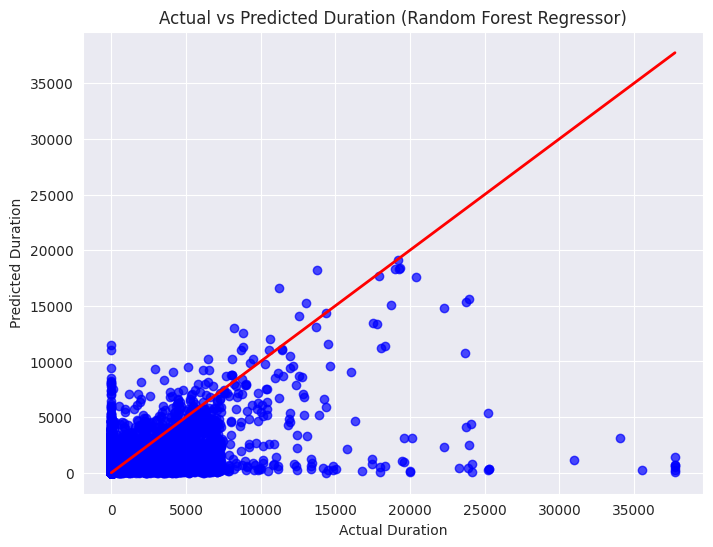

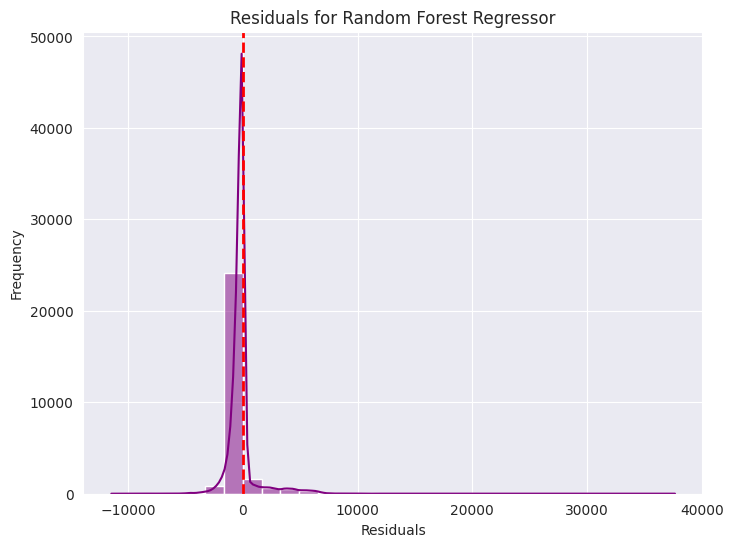

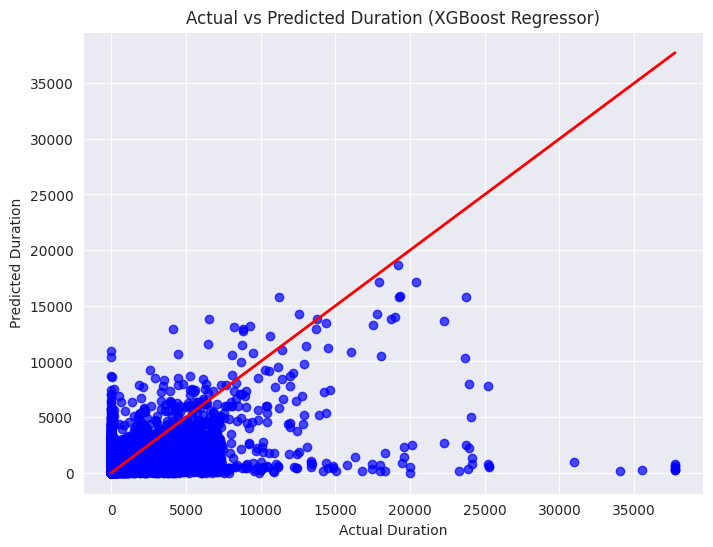

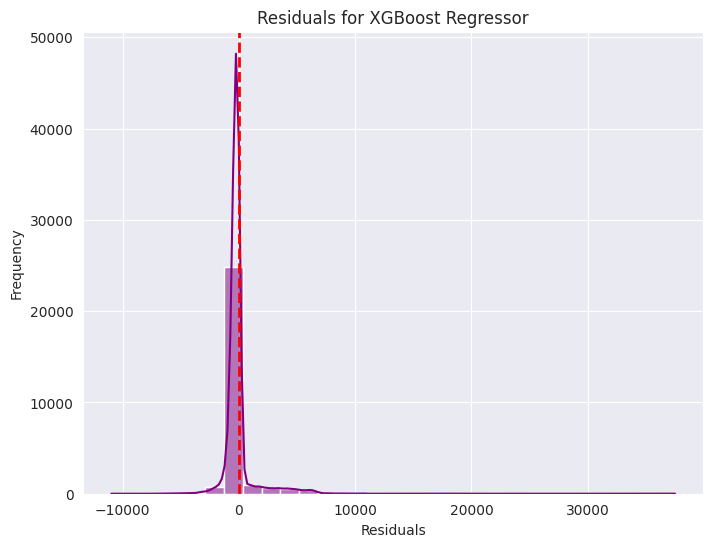

In [8]:
logging.info("Training models for construction duration prediction...")

X = df.drop(columns=["Duration", "ID", "Start_Time", "End_Time"])
y = df["Duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, n_jobs=-1),
    "XGBoost Regressor": XGBRegressor(n_jobs=-1)
}

def confidence_interval(y_true, y_pred, alpha=0.05):
    residuals = y_true - y_pred
    sigma = np.std(residuals, ddof=1)
    n = len(y_true)
    t_value = t.ppf(1 - alpha / 2, df=n-1)
    margin_of_error = t_value * (sigma / np.sqrt(n))
    return margin_of_error

def train_and_evaluate_regressor(name, model, alpha=0.05):
    logging.info(f"Training model: {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred < 0, 0, y_pred)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    ci = confidence_interval(y_test, y_pred, alpha)

    result = {
            'model': name,
            'MAE': mae,
            'RMSE': rmse,
            'R²': r2,
            "y_test": y_test,
            "y_pred": y_pred,
            "Confidence Interval": ci
    }

    return result

results = Parallel(n_jobs=-1, backend="threading")(
    delayed(train_and_evaluate_regressor)(name, model) for name, model in models.items()
)

for result in results:
    print(f"\n{result['model']}:")
    print(f"  MAE: {result['MAE']:.4f}")
    print(f"  RMSE: {result['RMSE']:.4f}")
    print(f"  R²: {result['R²']:.4f}")
    print(f"  95% CI: ±{result['Confidence Interval']:.4f}")

for result in results:
    plt.figure(figsize=(8, 6))
    plt.scatter(result['y_test'], result['y_pred'], alpha=0.7, color='blue')
    plt.plot([result['y_test'].min(), result['y_test'].max()], [result['y_test'].min(), result['y_test'].max()], color='red', lw=2)
    plt.xlabel("Actual Duration")
    plt.ylabel("Predicted Duration")
    plt.title(f"Actual vs Predicted Duration ({result['model']})")
    plt.show()

    residuals = result['y_test'] - result['y_pred']
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, color='purple', bins=30)
    plt.axvline(x=0, color='red', linestyle='--', lw=2)
    plt.title(f"Residuals for {result['model']}")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.show()


2025-04-03 21:11:39,935 - INFO - Starting model training for distance prediction...
2025-04-03 21:11:39,998 - INFO - Training model: Linear Regression...
2025-04-03 21:11:39,999 - INFO - Training model: Random Forest Regressor...
2025-04-03 21:11:39,999 - INFO - Training model: XGBoost Regressor...



Linear Regression:
  MAE: 0.5626
  RMSE: 1.5621
  R²: 0.1008
  MedAE: 0.3046
  95% CI: ±0.0182

Random Forest Regressor:
  MAE: 0.3561
  RMSE: 1.2693
  R²: 0.4063
  MedAE: 0.0846
  95% CI: ±0.0148

XGBoost Regressor:
  MAE: 0.4090
  RMSE: 1.3074
  R²: 0.3701
  MedAE: 0.1410
  95% CI: ±0.0152


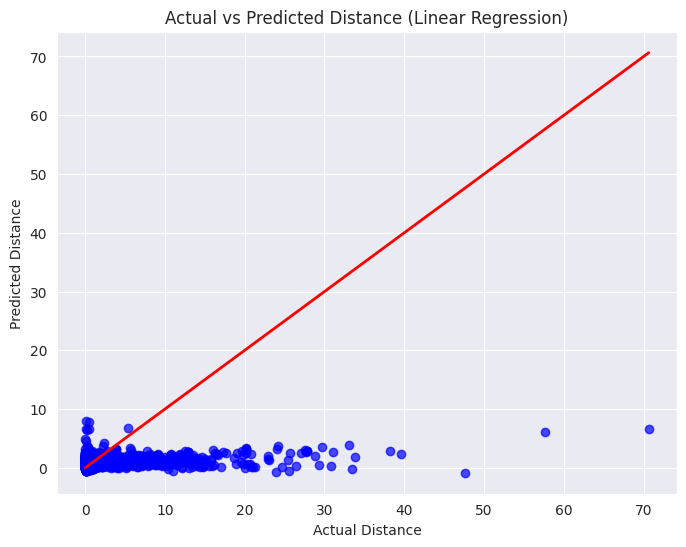

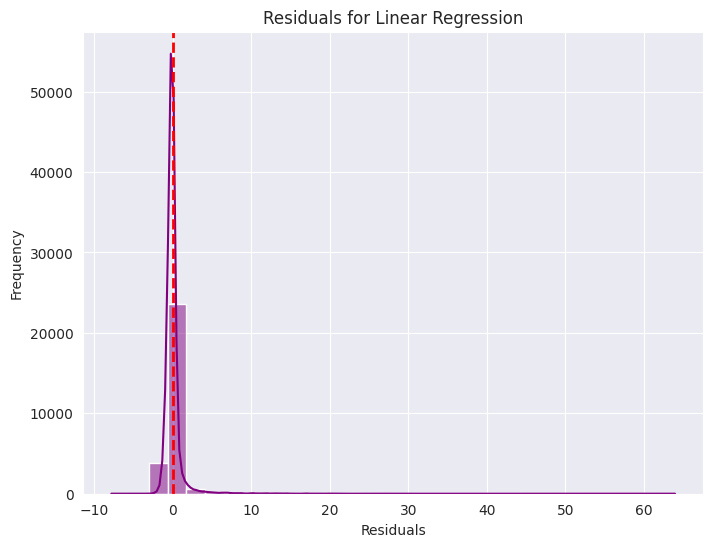

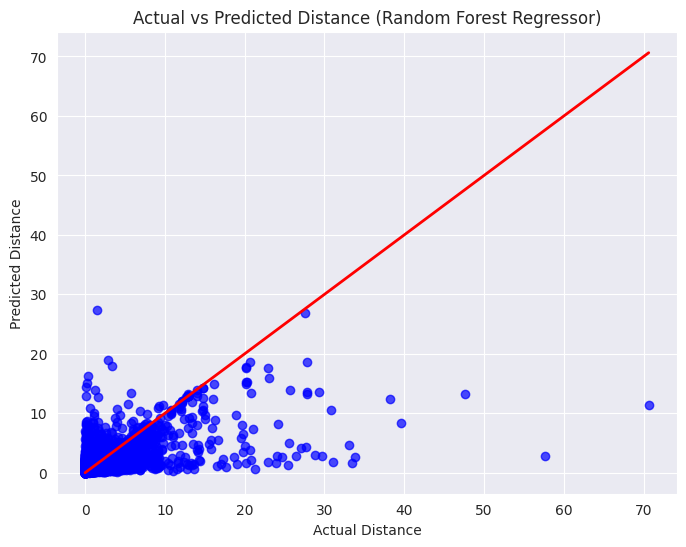

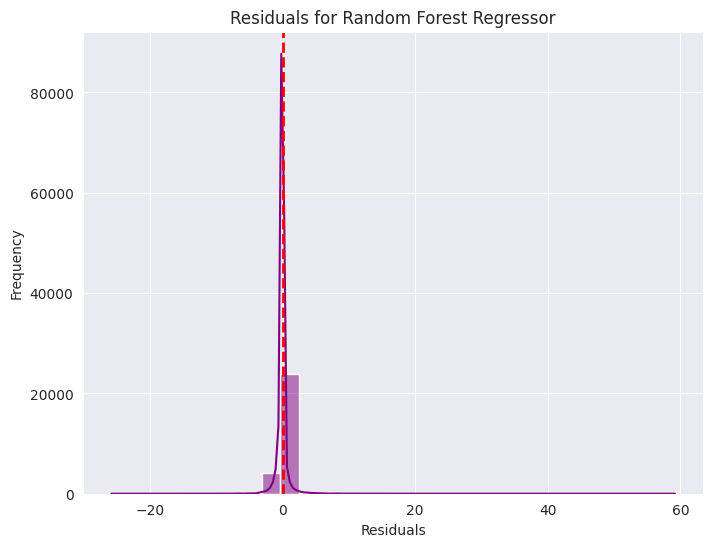

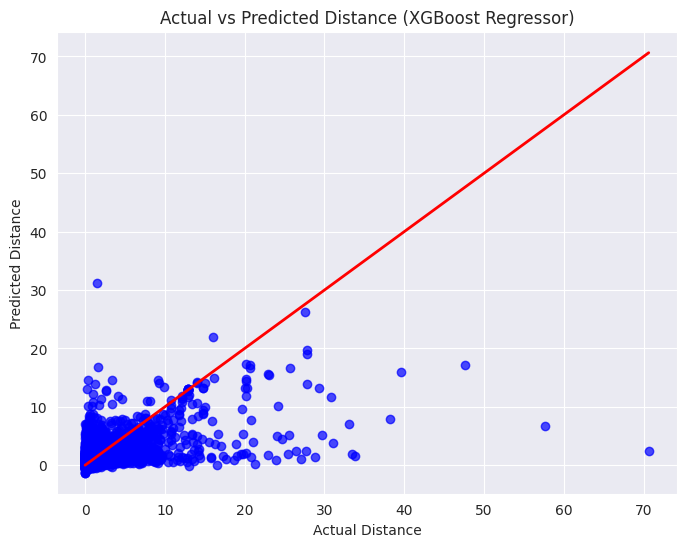

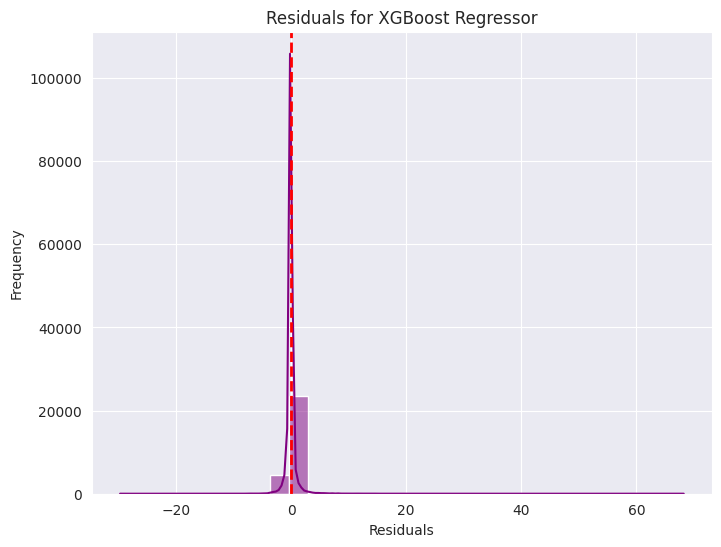

In [9]:
logging.info("Starting model training for distance prediction...")

X = df.drop(columns=["Distance(mi)", "ID", "Start_Time", "End_Time"])
y = df["Distance(mi)"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, n_jobs=-1),
    "XGBoost Regressor": XGBRegressor(n_jobs=-1)
}

def confidence_interval(y_true, y_pred, alpha=0.05):
    residuals = y_true - y_pred
    sigma = np.std(residuals, ddof=1)
    n = len(y_true)
    t_value = t.ppf(1 - alpha / 2, df=n-1)
    margin_of_error = t_value * (sigma / np.sqrt(n))
    return margin_of_error

def train_and_evaluate_regressor(name, model, alpha=0.05):
    logging.info(f"Training model: {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)

    ci = confidence_interval(y_test, y_pred, alpha)

    result = {
        'model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'MedAE': medae,
        "Confidence Interval": ci,
        "y_test": y_test,
        "y_pred": y_pred
    }
    return result

alpha = 0.05

results = Parallel(n_jobs=-1, backend="threading")(
    delayed(train_and_evaluate_regressor)(name, model, alpha) for name, model in models.items()
)

for result in results:
    print(f"\n{result['model']}:")
    print(f"  MAE: {result['MAE']:.4f}")
    print(f"  RMSE: {result['RMSE']:.4f}")
    print(f"  R²: {result['R²']:.4f}")
    print(f"  MedAE: {result['MedAE']:.4f}")
    print(f"  {100 * (1 - alpha):.0f}% CI: ±{result['Confidence Interval']:.4f}")

for result in results:
    plt.figure(figsize=(8, 6))
    plt.scatter(result['y_test'], result['y_pred'], alpha=0.7, color='blue')
    plt.plot([result['y_test'].min(), result['y_test'].max()], [result['y_test'].min(), result['y_test'].max()],
             color='red', lw=2)
    plt.xlabel("Actual Distance")
    plt.ylabel("Predicted Distance")
    plt.title(f"Actual vs Predicted Distance ({result['model']})")
    plt.show()

    residuals = result['y_test'] - result['y_pred']
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, color='purple', bins=30)
    plt.axvline(x=0, color='red', linestyle='--', lw=2)
    plt.title(f"Residuals for {result['model']}")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.show()


2025-04-03 21:37:14,494 - INFO - Starting association rule mining...



🔹 Discovered Association Rules:
        antecedents    consequents    support  confidence       lift
0        (Severity)  (Humidity(%)) 0.07587387  0.77837174 1.17160011
1  (Temperature(F))  (Humidity(%)) 0.04659465  0.40508111 0.60972548


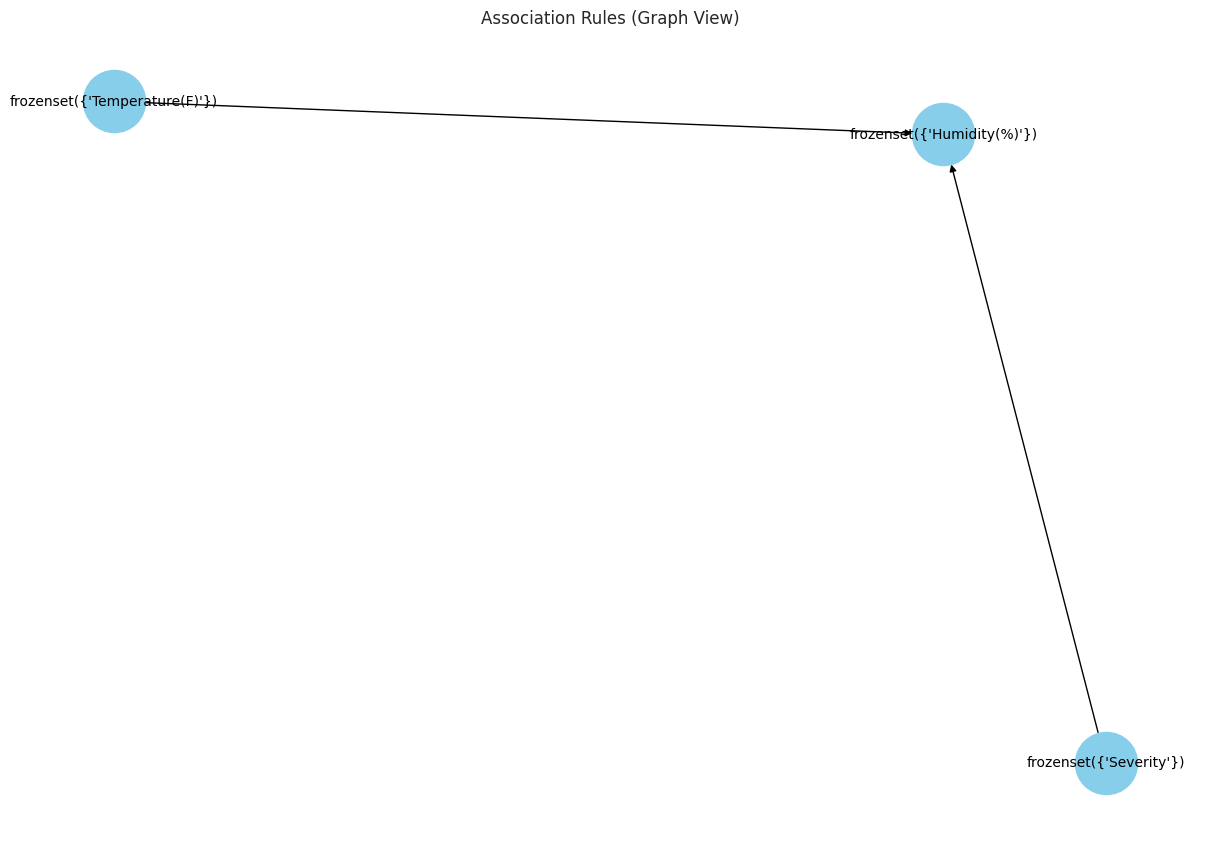

In [23]:
logging.info("Starting association rule mining...")

features = ["Severity", "Distance(mi)", "Temperature(F)", "Humidity(%)",
            "Precipitation(in)", "Wind_Speed(mph)", "Visibility(mi)"]
df_bin = df[features].copy()

for col in df_bin.columns:
    binarized = pd.cut(df_bin[col], bins=2, labels=False)
    df_bin[col] = binarized > 0

frequent_itemsets = apriori(df_bin, min_support=0.005, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.4)

print("\n🔹 Discovered Association Rules:")
print(rules[["antecedents", "consequents", "support", "confidence", "lift"]])

G = nx.DiGraph()

for _, rule in rules.iterrows():
    G.add_edge(str(rule['antecedents']), str(rule['consequents']),
               weight=rule['confidence'])

pos = nx.spring_layout(G)
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10)
plt.title("Association Rules (Graph View)")
plt.show()


2025-04-03 21:59:16,203 - INFO - Starting POI analysis for association rule mining...



🔹 Discovered Association Rules for POIs:
                                     antecedents       consequents    support  confidence       lift
0                            (Amenity, Crossing)  (Traffic_Signal) 0.05342506  0.84141067 2.72821617
1                             (Amenity, Railway)         (Station) 0.02115314  0.85268237 4.85510321
2                             (Amenity, Railway)  (Traffic_Signal) 0.02131510  0.85921090 2.78593220
3                             (Station, Railway)  (Traffic_Signal) 0.02278681  0.81204517 2.63300056
4                   (Amenity, Crossing, Railway)         (Station) 0.01542827  0.83594048 4.75977625
5             (Amenity, Traffic_Signal, Railway)        (Crossing) 0.01709715  0.80211430 3.09176388
6                   (Amenity, Crossing, Railway)  (Traffic_Signal) 0.01709715  0.92636398 3.00367145
7                   (Amenity, Crossing, Station)  (Traffic_Signal) 0.02918063  0.88039091 2.85460691
8             (Amenity, Traffic_Signal, Railway) 

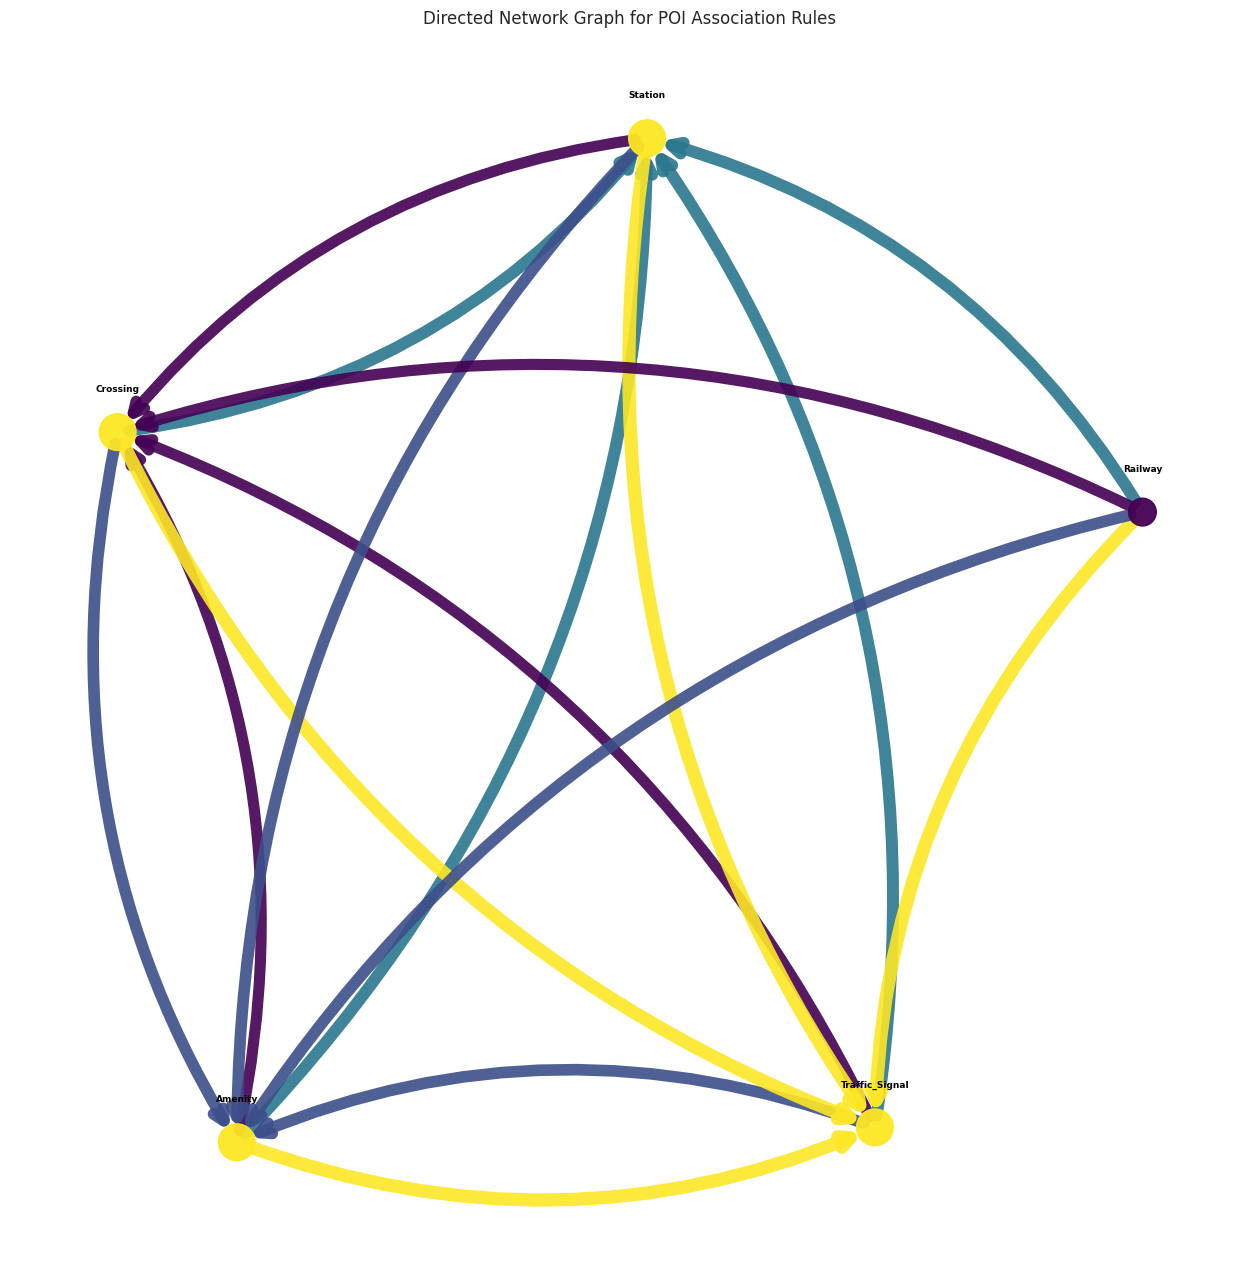

In [26]:
logging.info("Starting POI analysis for association rule mining...")

poi_columns = [
    "Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit",
    "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming",
    "Traffic_Signal", "Turning_Loop"
]

df_bin = df[poi_columns].copy()

df_bin = df_bin.astype(bool)

frequent_itemsets = apriori(df_bin, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8)

print("\n🔹 Discovered Association Rules for POIs:")
print(rules[["antecedents", "consequents", "support", "confidence", "lift"]])

G = nx.DiGraph()
for _, row in rules.iterrows():
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])
    for antecedent in antecedents:
        for consequent in consequents:
            G.add_edge(antecedent, consequent, weight=row['confidence'])

degree_dict = dict(G.degree())
node_size = [degree_dict[node] * 100 for node in G.nodes()]
node_colors = [degree_dict[node] for node in G.nodes()]

plt.figure(figsize=(16, 16))
pos = nx.spring_layout(G, seed=41, k=0.55)

nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                       cmap=plt.cm.viridis, node_size=node_size, alpha=0.95)

edges = [(u, v) for u, v in G.edges()]
weights = [G[u][v]['weight'] for u, v in edges]
norm = plt.Normalize(vmin=min(weights), vmax=max(weights))
edge_colors = plt.cm.viridis(norm(weights))
nx.draw_networkx_edges(G, pos, edgelist=edges,
                       width=[w * 10 for w in weights],
                       edge_color=edge_colors, alpha=0.9,
                       arrowstyle='->', arrowsize=20,
                       connectionstyle="arc3,rad=0.2")

label_pos = {node: (x, y + 0.07) for node, (x, y) in pos.items()}
nx.draw_networkx_labels(G, label_pos, font_size=6.5, font_weight="bold",
                        font_color="black")

plt.title("Directed Network Graph for POI Association Rules")
plt.axis("off")
plt.show()